# Credit Risk and Fraud Detection Analysis
**Author:** Philip Zhang

**Project:** Hybrid Machine Learning Model for Loan Default Prediction

**Context:** This project uses a dataset of 32,581 loan records to build a two layer risk detection system, addressing both credit risk (defaults) and potential fraud (anomalies).

**Key Goals:**
- **Maximize Recall:** Prioritize minimizing "False Negatives" (missed defaults).

- **Business Focus:** Shift the metric of success from raw accuracy to financial risk reduction.
- **Hybrid Architecture:** Implement a two-stage approach:
    1.  **Random Forest (Supervised):** To identify known risk patterns based on historical data.
    2.  **Isolation Forest (Unsupervised):** To act as a "safety net" for detecting  anomalies and edge cases that the supervised model would miss.

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, precision_score

# Custom Modules (from src folder)
from src.processing import load_clean_data
from src.modeling import train_rf, train_if, train_lr

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

Before cleaning, I analyzed the raw data to assess the risk distribution and identify data quality issues.

In [11]:
# Load raw data for exploration
df_raw = pd.read_csv('data/credit_risk_dataset.csv')

In [12]:
# View prediction distribution 
status_counts = df_raw['loan_status'].value_counts(normalize=True)
print(status_counts)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64


In [13]:
# Stats summary
print(df_raw.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

In [14]:
# Checking for missing values
df_raw.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

#### **Key EDA Insights**
Class Imbalance (~22% Defaults):
* **Observation:** Non-defaults outnumber defaults significantly.

* **Action:** Focus on **Recall** and **F1-Score** instead of using accuracy that will be misleading.
    
Data Integrity Issues:
* **Observation:** Summary statistics revealed impossible outliers 

* **Action:** Filter out to only keep records with `person_age` < 100 and `person_emp_length` < 60.

Missing Values:
* **Observation:** Missing data from `employment_length` and `loan_int_rate`.

* **Action:** Impute missing values using **Segmented Imputation** based on direct correlations
    * Employment: Filled based on `person_home_ownership` 
    
    * Interest Rate: Filled based on `loan_grade` 

## Preprocessing 
I implemented the cleaning strategy above, applied **One-Hot Encoding** to categorical variables, and mapped `loan_grade` to numeric values to translate the data to machine-readable. 

In [15]:
# Preprocessing using function
df = load_clean_data('data/credit_risk_dataset.csv')

# Define predictors and predicting
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split data using 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Model Architecture

### Baseline Model: Logistic Regression
I started with a linear model to establish a performance baseline. While Logistic Regression is highly interpretable, it assumes a linear relationship between all features and risk. My primary goal here is to benchmark **Recall** before moving to more complex non-linear models.

In [16]:
# Train 
lr_model = train_lr(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      4971
           1       0.77      0.19      0.30      1365

    accuracy                           0.81      6336
   macro avg       0.79      0.59      0.60      6336
weighted avg       0.80      0.81      0.76      6336



**Baseline Analysis**
* **Accuracy (0.81):** The high accuracy is misleading because of the class imbalance. 

* **F1-Score (0.30):** The low F1-score reveals the truth that the model is failing to balance Precision and Recall.
* **Recall (0.19):** The linear model only detected **19%** of actual defaults. This indicates that **the risk factors have non-linear relationships*** that a linear decision boundary cannot capture.
* **Decision:** Move to **Random Forest** (a tree-base model) to capture the non-linear patterns. Additionally, I will apply `class_weight='balanced'` to help the model prioritize catching defaults. 

### Improved Model: Random Forest

* **Architecture:** An ensemble method that uses 100 decision trees to capture non-linear interactions (e.g., high income is only safe if debt is low).

* **Key Configurations:**
    * `n_estimators=100`: Builds 100 trees to improve model stability and reduce variance. 
    
    * `'class_weight'balanced'`: Forces the model to prioritize the minority class (Defaults) by penalizing missed mistakes on them more heavily.

In [17]:
# Train
rf_model = train_rf(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4971
           1       0.97      0.72      0.83      1365

    accuracy                           0.93      6336
   macro avg       0.95      0.86      0.89      6336
weighted avg       0.94      0.93      0.93      6336



**Random Forest Analysis**
* **F1-Score (0.83):** This improved score confirms the model is balanced and effective at finding defaults with being accurate. 

* **Recall Surge (0.72):** The model captures **72%** of defaults (up from 19% in the baseline), confirming the non-linear data relationships were successfully mapped.
* **Precision (0.97):** The model is extremely precise when predicting defaults at **97%**. However, the large gap between Precision and Recall indicates the model is **conservative** where it avoids false alarms at the cost of missing risky applicants.   
* **Next Steps:** Since we have the gap, we can optimize the **classification threshold** to be more aggressive in catching defaults.

#### Threshold Optimization

The default threshold is **0.50** (if probability > 50%, predict Default). However, in credit risk, missing a default (False Negatives) is far more costly than flagging a safe applicant (False Positives). 
* **Goal:** Increase Recall (prioritize catching defaults)

* **Method:** I plotted the thresholds from 0.1 to 0.5 to identify which threshold was most optimal to maintain above **0.80** for Recall while keeping Precision above **0.70.**  

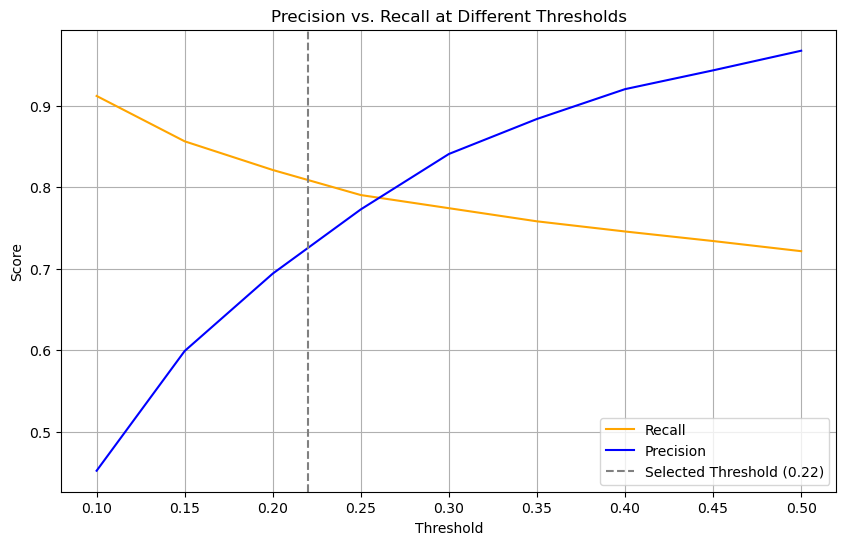

Performance at Threshold 0.22
Recall:    0.81
Precision: 0.71


In [18]:
# Get the raw probabilities
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Define threshold range
thresholds = np.arange(0.1, 0.55, 0.05)
recalls = []
precisions = []

# Loop for scores for each threshold
for t in thresholds:
    y_pred_temp = (y_prob >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_temp))
    precisions.append(precision_score(y_test, y_pred_temp))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, precisions, label='Precision', color='blue')

# Vertical line for selected threshold
plt.axvline(x=0.22, color='gray', linestyle='--', label='Selected Threshold (0.22)')

plt.title('Precision vs. Recall at Different Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Get the threshold specific values for Recall and Precision 
t = 0.22
y_pred_specific = (y_prob >= t).astype(int)

print(f"Performance at Threshold {t}")
print(f"Recall:    {recall_score(y_test, y_pred_specific):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_specific):.2f}")

**Tuning Results:**
* **Optimal Threshold (0.22):** I adjusted the decision boundary from 0.5 down to 0.22 based on the visualization. 

* **Trade-off:** This increased the Recall to **81%** while maintaining an acceptable Precision of **71%**.
* **Business Impact:** This tuned model is safer for banks because it prioritizes catching risky loans to avoid financial losses, while keeping false alarms manageable.

#### Feature Importance Analysis

To interpret the results of the model, I visualized the importance of each feature to validate whether the model is making decisions based on financial factors rather than noise. 

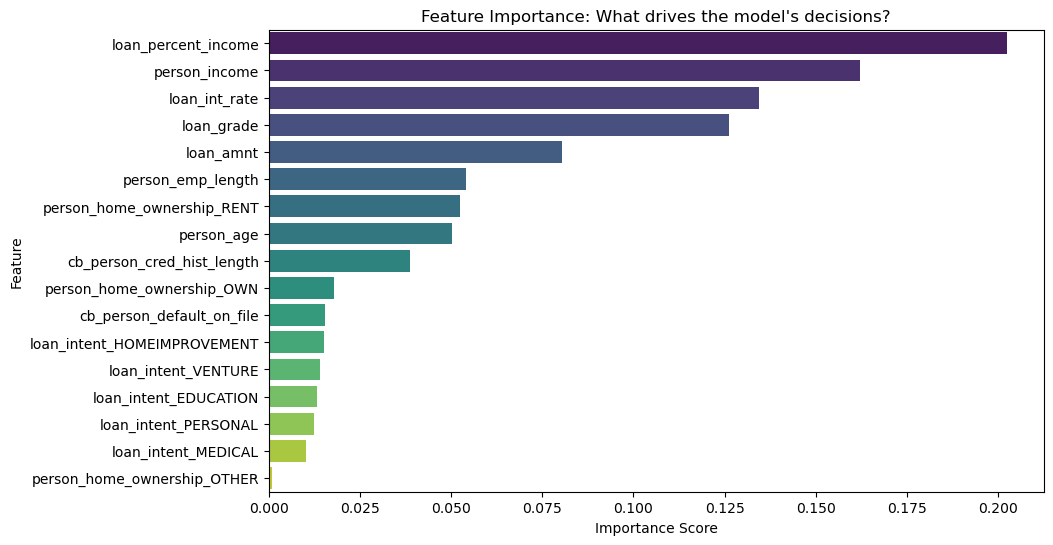

In [19]:
# Extract Feature Importances
importances = rf_model.feature_importances_

# Sort to show most important at the top
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance: What drives the model's decisions?")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

**Random Forest Insights:**
* **Key Drivers:** The model correctly identifies `loan_percent_income` and `person_income` as the strongest predictors.

* **Interpretation:** This aligns with financial logic: applicants borrowing a large percent of their income are statistically riskier. This confirms the model is learning valid economic patterns.
* **Limitation:** While effective, the model is confined to historical patterns. **It can only detect risky applicants who resemble past defaulters.** 
* **Solution:** To detect **potential anomalies or frauds** that the supervised model cannot find, I will introduce a Unsupervised Learning Layer that looks for hidden patterns.

### Unsupervised Anomaly Detection

#### Anomaly Detection Layer: Isolation Forest

**Goal:** Detect outlier applicants whose data profiles are "weird/rare" compared to the general population that acts as a safety net.

In [20]:
# Train
iso_model = train_if(X_train)

# Predict
iso_preds = iso_model.predict(X_test)

#### Integrated Analysis: Identifying "Hidden Risks"

**Method:** Combining both predictive powers of the Random Forest and Isolation Forest to create a robust risk framework.

We define a **"Hidden Risk"** as an applicant who:
1. **Passed the Main Check:** Random Forest predicts "Safe" (0)
2. **Failed the Outlier Check:** Isolated Forest predicts "Anomaly" (-1)

**Business Action:** These applications shouldn't necessarily be rejected, but they should be flagged for **manual review** because they look safe on the surface but have irregular patterns inside.

In [21]:
# Get Random Forest predictions 
rf_preds = rf_model.predict(X_test)

# Create a specific DataFrame for analysis, copying to not modify original X_test variable
analysis_df = X_test.copy()

# Add predictions to the analysis DataFrame, bringing in Feature Data + RF Results + Anomaly Scores into one table.
analysis_df['RF_Prediction'] = rf_preds
analysis_df['Anomaly_Score'] = iso_preds 
analysis_df['Anomaly_Label'] = analysis_df['Anomaly_Score']

# Filter for Hidden Risks
# Logic: RF says Safe (0), but Iso says Anomaly (-1)
hidden_risks = analysis_df[ 
    (analysis_df['RF_Prediction'] == 0) & 
    (analysis_df['Anomaly_Label'] == -1) 
]

print(f"Number of 'Hidden Risk' applicants: {len(hidden_risks)}\n")
print("Sample of Hidden Risks:")
print(hidden_risks[['person_income', 'loan_percent_income', 'person_emp_length', 'person_age', 'loan_int_rate', 'cb_person_cred_hist_length','RF_Prediction', 'Anomaly_Label']].head(10))

Number of 'Hidden Risk' applicants: 216

Sample of Hidden Risks:
       person_income  loan_percent_income  person_emp_length  person_age  \
32410          71000                 0.10               14.0          51   
32485          24000                 0.13                1.0          64   
27003          25000                 0.40                5.0          29   
23194          60000                 0.42               11.0          35   
5223          143000                 0.06                7.0          24   
28680         250000                 0.06                8.0          35   
32489          85000                 0.11               11.0          61   
27710         170000                 0.12               15.0          33   
5590           39000                 0.64                0.0          22   
31788         142000                 0.18                2.0          40   

       loan_int_rate  cb_person_cred_hist_length  RF_Prediction  Anomaly_Label  
32410          13

**Isolation Forest Findings**
The Isolation Forest successfully identified **216 "Hidden Risk" applicants**. These are individuals the Random Forest approved (predicted "Safe"), but whose financial profiles are highly unusal compared to the norm.

**Key Observations from the Sample:**

* **The Low-Income Veteran (Index 32485):**
    * **Profile:** Age 64, 21 years of credit history, but only $24,000 income.
    
    * **Analysis:** The Random Forest likely trusted this applicant because of their long credit history. However, the Isolation Forest flagged the mismatch: **it is unusal to have such a long history with such low income.** This could indicate a retiree with limited cash flow who might struggle to repay a new loan. 

* **The Over-Leveraged Borrow (Index 5590):**
    * **Profile:** Age 22, 0 years employment, asking for a loan equal to 64% of their income.

    * **Analysis:** The supervised model might have approved this based on other factors but the Isolation Forest flagged the ratio asked: **borrowing 64% of your income while unemployed is extremely dangerous**. 

* **The Suspicious High-Earner (Index 5223):**
    * **Profile:** Age 24, $143,000 income, with a short credit history.
    
    * **Analysis:** While high income is usually positive, earning this much at age 24 is rare. **The model's decision to flag isn't necessarily because the applicant is 'bad' but to verify the data is correct.** 

**Business Value:**
The Hybrid Architecture succeeds where the Single Model failed. The Random Forest was occasionally "fooled" by long credit histories or high incomes, whereas the Isolation Forest caught the inconsistencies in the data. The addition of the Isolation Forest successfully created a safety net for applicants that need a manual check rather than automatic approval.

#### Visualizing the Hidden Risks
To better understand the distinction between **Normal Applicants** and **Hidden Risks**, I plotted the test set results using scatter matrix to compare key features. 

* **Grey Dots (Normal Safe):** Applicants approved by both models.

* **Red Dots (Hidden Risks):** Applicants approved by the Random Forest but flagged by the Isolation Forest.

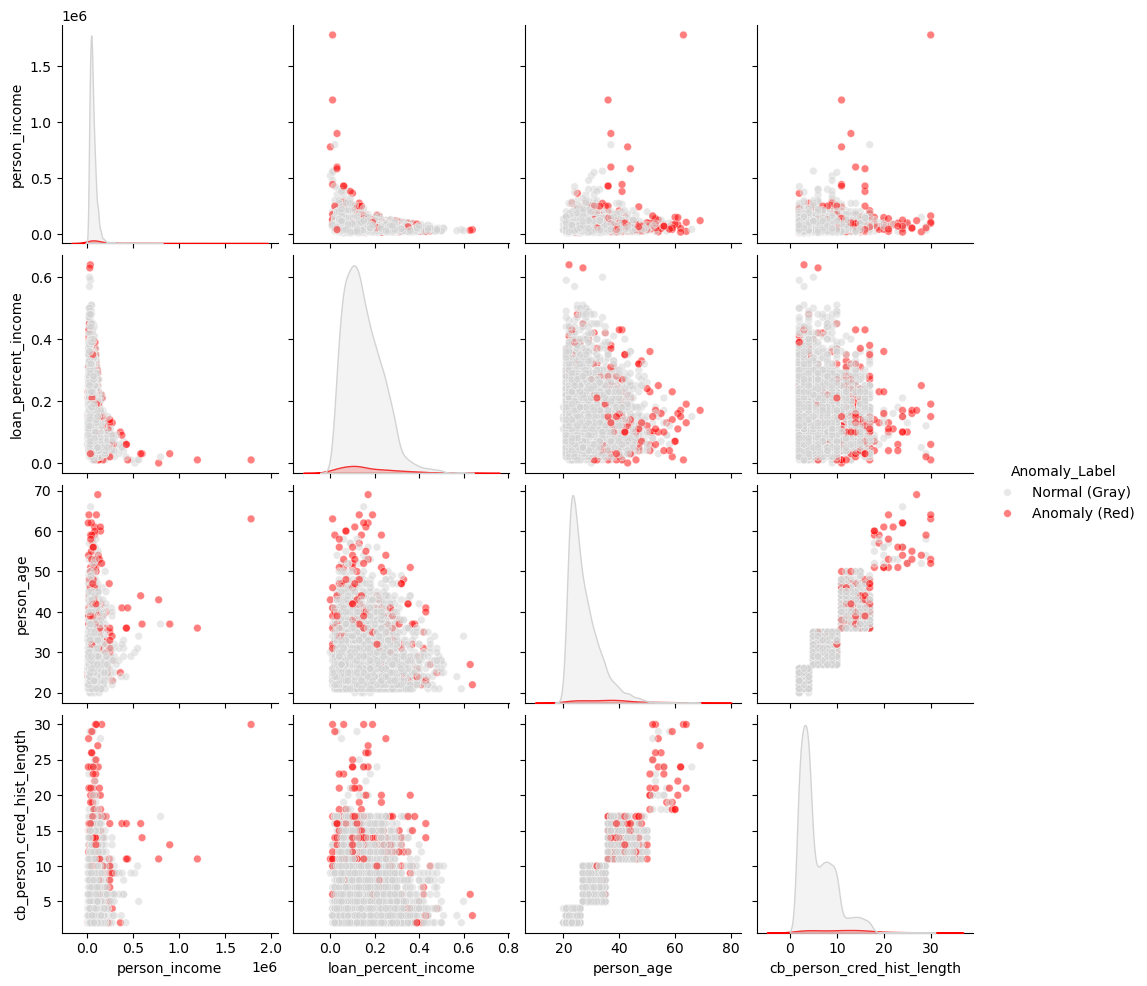

In [22]:
# Setup Data
pairplot_df = X_test.copy()
pairplot_df['Anomaly_Label'] = iso_model.predict(X_test)
pairplot_df['Anomaly_Label'] = pairplot_df['Anomaly_Label'].map({-1: 'Anomaly (Red)', 1: 'Normal (Gray)'})

# Filter for safe applicants from the Random Forest
pairplot_df = pairplot_df[rf_model.predict(X_test) == 0]

# Select four key features
cols_to_plot = ['person_income', 'loan_percent_income', 'person_age', 'cb_person_cred_hist_length', 'Anomaly_Label']

# Generate the grid
sns.pairplot(pairplot_df[cols_to_plot], 
             hue='Anomaly_Label', 
             palette={'Anomaly (Red)': 'red', 'Normal (Gray)': 'lightgrey'},
             plot_kws={'alpha': 0.5, 's': 30}) # s is dot size

plt.show()

**Visualization Insights:**

* **Edge Behavior:** The Red Dots rarely appear in the dense center of clusters. Instead, they occupy the edges of the graph that represent the extreme values (like massive loans or zero incomes found in Sample Index 5590 and 5223).

* **Cluster Density:** Whereas the Red Dots appear on the outside, the Grey Dots form a dense cloud in the center. These applicants share standard characteristics that are deemed "safe". 
* **Multidimensional Outliers:** Despite the pattern of edge behavior for red points, there are also some located in the grey dense clusters. These are outliers that may not be visible in this specific 2D view. An applicant might look normal in *Age vs. Income,* but is actually an extreme outlier in *Debt vs. Employment.* The model sees all dimensions at once, but this plot only shows two at a time.
* **Conclusion:** The clear visual separation between the Grey and Red points illustrate the use case for Isolation Forest in potential fraud detection. While the Random Forest sees credit history, the Isolation Forest identifies irregular patterns. It specifically flags applicants who look safe on paper but exhibit behavior that is different than the general population, making it a strong indicator potential fraud. 

### Project Summary

**Objective:** Develop a machine learning pipeline to predict loan defaults and identify high risk applicants.

**Primary Solution:** I trained a Random Forest Classifier and optimized the decision threshold to **0.22**
* **Impact:** This improved the model's ability to catch defaults (Recall) to **81%**. While this lowered the Precision, the model remains viable for real-world application where risk reduction is the priority. 
    
**Safety Layer:** I implemented an Isolation Forest (Unsupervised Learning) to detect "Hidden Risks".
* **Impact:** This acts as a safety net which flagged **216 applicants** who passed the initial check but exhibited abnormal patterns. 
 
**Recommendation:** The bank should use Random Forest for automated decision-making and Isolation Forest for manual review. This hybrid approach balances the speed effiency with safety measures. 